# Analyse cellular and temporal singular vectors to see if anything generalises across tasks 

In [ ]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
import scipy.stats as stt
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

In [2]:
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix

def zscore(dat): return (dat-np.mean(dat))/np.std(dat)

In [3]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [4]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

sys.path.append("/Users/yves/Documents/Code/mec_ephys/packages/mecll/")
from SVD_analysis import *

In [5]:
def load_data(selected_session,by_dir=False):
    
    """ Function to load data structured according to the format
        that the data were delivered to the retreat for
    """
    all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
    all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
    root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
    spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


    #This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
    spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

    #This is basically a big table (you can open it in excel) which contains
    #relevant information about each time the animal poked one of the ports
    task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

    #
    response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
    #alternatively to change the time window


    #not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
    single_units = np.load(os.path.join(root_dir,'single_units.npy'))
    
    
    seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
    seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))
    
    
    graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    graph_type1 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    
    if by_dir:
        firing_rate_maps = get_task_responses_by_direction(task_event_df,response_table)
    else:
        firing_rate_maps = get_task_responses(task_event_df,response_table)
    
    return firing_rate_maps, task_event_df,seq0,seq1,graph_type0,graph_type1

In [6]:
def get_task_responses_by_direction(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction,2]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                                (task_event_df['correct']==True) &  #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                n_trials = len(table_index)
                half_trials = np.floor_divide(n_trials,2)
                #print(table_index)
                #np.random.shuffle(table_index)
                vals = response_table[table_index]
                #print(vals.shape)
                n_vals = np.arange(vals.shape[0])
                #np.random.shuffle(vals)
                vals= vals[np.random.permutation(n_vals)]
                if n_trials>=4:
                    for half,half_vals in enumerate([vals[:half_trials],vals[half_trials:]]):
                        firing_rate_maps[:,int(port),int(task),dix,half] = np.nanmean(half_vals,axis=0)
                else:
                    firing_rate_maps[:,int(port),int(task),dix] = np.nan#np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [7]:
firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(0,by_dir=True)


In [8]:
#neuron x port_nr x task x direction x data_half
#firing_rate_maps

In [9]:
def zscore_firing_rate_maps(x):
    """
    x are the firing rate maps with shape 
    neuron x port_nr x task x direction x data_half
    """
    x = (x - np.mean(x,axis=(1,2,3,4))[:,None,None,None,None])/np.std(x,axis=(1,2,3,4))[:,None,None,None,None]
    x = np.nan_to_num(x,0)
    return x

In [10]:
firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(6,by_dir=True)


In [11]:
mx = np.nanmax(firing_rate_maps,axis=(1,2,3,4))
selected = ~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3,4)))
firing_rate_maps = firing_rate_maps[:,selected]
firing_rate_maps = firing_rate_maps[np.logical_and(mx>.1,mx<100)]
firing_rate_maps = zscore_firing_rate_maps(firing_rate_maps)
firing_rate_maps = np.nan_to_num(firing_rate_maps,0)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [12]:
~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3,4)))

array([ True,  True,  True,  True,  True,  True,  True])

In [13]:
from functools import partial

In [58]:
def subset_data(x,task,direction,half):
    return x[:,:,task,direction,half]
#select_data = partial(subset_data,x=firing_rate_maps)

In [15]:
select_data = lambda task,direction,half: subset_data(firing_rate_maps,task,direction,half)

In [16]:
res = []
for ref,cv in zip([0,1],[1,0]):
    for tar in [0,1]:
        for task in [0,1]:
            for dir1,dir2 in zip([0,1],[1,0]):
                tmp = variance_explained_U(select_data(task=task,direction=dir1,half=ref),
                                   select_data(task=task,direction=dir1,half=cv),
                                   select_data(task=task,direction=dir2,half=tar)
                                 )
                res.append(tmp)

In [17]:
# res = []
# for ref,cv in zip([0,1],[1,0]):
#     for tar in [0,1]:
#         for dir1 in [0,1]:
#             for task1,task2 in zip([0,1],[1,0]):
#                 tmp = variance_explained_U(select_data(task=task1,direction=dir1,half=ref),
#                                    select_data(task=task1,direction=dir1,half=cv),
#                                    select_data(task=task2,direction=dir1,half=tar)
#                                  )
#                 res.append(tmp)

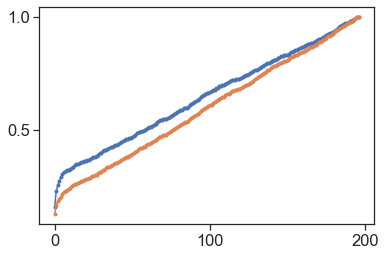

In [18]:
plt.plot(np.cumsum(np.mean(np.array(res)[:,0],axis=0)),marker='.')
plt.plot(np.cumsum(np.mean(np.array(res)[:,1],axis=0)),marker='.')
plt.locator_params(nbins=3)

# Batch this

## Compare directions

In [19]:
all_res_dir = []
for sess_ix in range(8):
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
    #select_data = lambda task,direction,half: subset_data(firing_rate_maps,task,direction,half)
    mx = np.nanmax(firing_rate_maps,axis=(1,2,3,4))
    selected = ~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3,4)))
    firing_rate_maps = firing_rate_maps[:,selected]
    firing_rate_maps = firing_rate_maps[np.logical_and(mx>.1,mx<100)]
    #firing_rate_maps = zscore_firing_rate_maps(firing_rate_maps)
    select_data = lambda task,direction,half: subset_data(firing_rate_maps,task,direction,half)

    res = []
    for ref,cv in zip([0,1],[1,0]):
        for tar in [0,1]:
            for task in [0,1]:
                for dir1,dir2 in zip([0,1],[1,0]):
                    
                    dset1 = select_data(task=task,direction=dir1,half=ref)
                    dset2 = select_data(task=task,direction=dir1,half=cv)
                    dset3 = select_data(task=task,direction=dir2,half=tar)
                    
                    dset1 = dset1 - np.mean(dset1,axis=1)[:,None]
                    dset2 = dset2 - np.mean(dset2,axis=1)[:,None]
                    dset3 = dset3 - np.mean(dset3,axis=1)[:,None]
                    #if you don't de-mean here, you are losing information about differences
                    #in mean firing rate...
                    tmp = variance_explained_U(dset1,dset2,dset3)
                    res.append(tmp)
    all_res_dir.append(res)

In [20]:
dset1.shape

(393, 7)

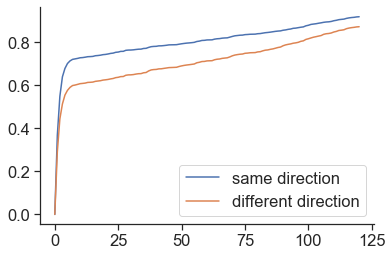

In [21]:
d1_dir = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res_dir]),axis=1),axis=2),axis=0)[0]
d2_dir = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res_dir]),axis=1),axis=2),axis=0)[1]

plt.plot(np.concatenate([[0],d1_dir]),label='same direction')
plt.plot(np.concatenate([[0],d2_dir]),label='different direction')
plt.legend()
seaborn.despine()

## Compare task

In [77]:
REMOVE_SPACE = True
all_res_task = []
for sess_ix in range(8):
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
    mx = np.nanmax(firing_rate_maps,axis=(1,2,3,4))
    selected = ~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3,4)))
    firing_rate_maps = firing_rate_maps[:,selected]
    firing_rate_maps = firing_rate_maps[np.logical_and(mx>.1,mx<100)]
    #firing_rate_maps = zscore_firing_rate_maps(firing_rate_maps)
    select_data = lambda task,direction,half: subset_data(firing_rate_maps,task,direction,half)

    res = []
    for ref,cv in zip([0,1],[1,0]):
        for tar in [0,1]:
            for dir1 in [0,1]:
                for task1,task2 in zip([0,1],[1,0]):
                    
                    dset1 = select_data(task=task1,direction=dir1,half=ref)
                    dset2 = select_data(task=task1,direction=dir1,half=cv)
                    dset3 = select_data(task=task2,direction=dir1,half=tar)
                    
                    if REMOVE_SPACE:
                        spatial_responses = np.nanmean(np.dstack([dset1,dset2,2*dset3]),axis=2)
                        dset1 = dset1 - spatial_responses
                        dset2 = dset2 - spatial_responses
                        dset3 = dset3 - spatial_responses
                    #if you don't de-mean here, you are losing information about differences
                    #in mean firing rate...
                    dset1 = dset1 - np.mean(dset1,axis=1)[:,None]
                    dset2 = dset2 - np.mean(dset2,axis=1)[:,None]
                    dset3 = dset3 - np.mean(dset3,axis=1)[:,None]
                    #if you don't de-mean here, you are losing information about differences
                    #in mean firing rate...
                    tmp = variance_explained_U(dset1,dset2,dset3
                                     )
                    res.append(tmp)
    all_res_task.append(res)

In [78]:
                    dset2 = select_data(task=task1,direction=dir1,half=cv)
                    dset3 = select_data(task=task2,direction=dir1,half=tar)


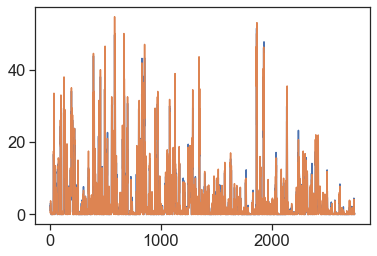

In [79]:
plt.plot((dset2+dset3).flatten()/2)
plt.plot((dset2).flatten())

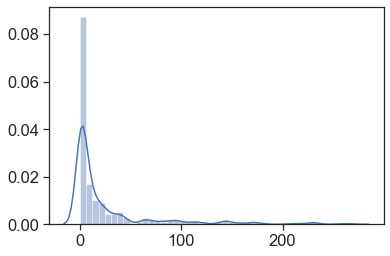

In [80]:
seaborn.distplot(np.nanmean(np.dstack([dset2,dset3]),axis=2).sum(axis=1))

In [81]:
d1 = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res_task]),axis=1),axis=2),axis=0)[0]
d2 = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res_task]),axis=1),axis=2),axis=0)[1]


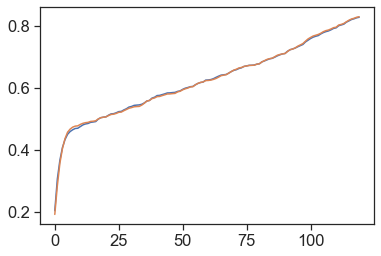

In [82]:
plt.plot(d1)
plt.plot(d2)

In [28]:
import scipy.stats as stt

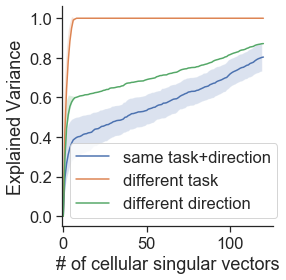

In [29]:
NSTD = 1.96
plt.figure(figsize=(4,4))
d1 = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res_task]),axis=1),axis=2),axis=0)[0]
d2 = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res_task]),axis=1),axis=2),axis=0)[1]


d1_sem = stt.sem(np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res_task]),axis=1),axis=2),axis=0)[0]
d2_sem = stt.sem(np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res_task]),axis=1),axis=2),axis=0)[1]


#d1 = np.cumsum(np(np.array([np.array(i)[:,:,:120] for i in all_res]),axis=(0,1))[0])
#d2 = np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res]),axis=(0,1))[1])

plt.plot(np.concatenate([[0],d1]),label='same task+direction')
plt.fill_between(np.arange(120),d1-NSTD*d1_sem,d1+NSTD*d1_sem,alpha=.2)

plt.plot(np.concatenate([[0],d2]),label='different task')
plt.fill_between(np.arange(120),d2-NSTD*d2_sem,d2+NSTD*d2_sem,alpha=.2)

plt.plot(np.concatenate([[0],d2_dir]),label='different direction')
plt.fill_between(np.arange(120),d2_dir-NSTD*d2_sem,d2_dir+NSTD*d2_sem,alpha=.2)

#plt.xlim(0,25)
plt.ylabel("Explained Variance")
plt.xlabel("# of cellular singular vectors")
plt.legend()
plt.xlim(-1)
seaborn.despine()
plt.tight_layout()
#plt.savefig("/Users/yves/Documents/cosyne_figures/SVD_fig.svg")
#plt.savefig("/Users/yves/Documents/cosyne_figures/SVD_fig.png",dpi=300)

# Run over both

In [57]:

def variance_explained_both(store_ref,store_cv,store_alt):

    U,S,Vt = np.linalg.svd(store_ref)
    #Vt = np.random.normal(size=Vt.shape)

    
    ev_cv = U.T.dot(store_cv).dot(Vt.T).diagonal()**2
    norm_ev_cv = ev_cv/np.sum(ev_cv)
    
    
    ev_alt = U.T.dot(store_alt).dot(Vt.T).diagonal()**2
    norm_ev_alt = ev_alt/np.sum(ev_cv)

    
    return norm_ev_cv, norm_ev_alt

In [58]:
all_res_uv = []
for sess_ix in range(1,8):
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
#   seq0 = np.random.permutation(seq0)
#   seq1 = np.random.permutation(seq1)
    frm = firing_rate_maps.copy()
    #neuron_nr,int(port),int(task),dix,half
    frm[:,:,0] = firing_rate_maps.swapaxes(0,1)[seq0,:,0].swapaxes(0,1)
    frm[:,:,1] = firing_rate_maps.swapaxes(0,1)[seq1,:,1].swapaxes(0,1)
    mx = np.nanmax(frm,axis=(1,2,3,4))
    frm = frm[np.logical_and(mx>.01,mx<100)]
    
    #seqs = [seq0,seq1]
    #mx = np.nanmax(frm,axis=(1,2,3,4))
    selected = ~np.isnan(np.sum(frm,axis=(0,2,3,4)))
    frm = frm[:,selected]
    frm2 = frm.copy()
    select_data = lambda task,direction,half,fr: subset_data(fr,task,direction,half)
    #firing_rate_maps = zscore_firing_rate_maps(firing_rate_maps)

    res = []
    for ref,cv in zip([0,1],[1,0]):
        for tar in [0,1]:
            for dir1 in [0,1]:
                for task1,task2 in zip([0,1],[1,0]):
                    
                    #print(task1==task2)
                    dset1 = select_data(task=task1,direction=dir1,half=ref,fr=frm2)
                    dset2 = select_data(task=task1,direction=dir1,half=cv,fr=frm2)
                    dset3 = select_data(task=task2,direction=dir1,half=tar,fr=frm2)
            
                    
                    #afg
                    #1/0
                    #break
                    dset1 = dset1 - np.mean(dset1,axis=1)[:,None]
                    dset2 = dset2 - np.mean(dset2,axis=1)[:,None]
                    dset3 = dset3 - np.mean(dset3,axis=1)[:,None]
                    #if you don't de-mean here, you are losing information about differences
                    #in mean firing rate...
                    tmp = variance_explained_both(dset1,dset2,dset3)
                    res.append(tmp)
    all_res_uv.append(res)

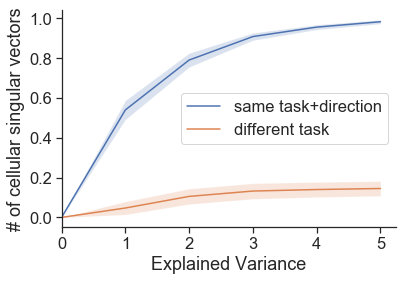

In [59]:
NSTD = 1.96



d1 = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[0]
d2 = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[1]
d1 = np.concatenate([[0],d1]); d2 = np.concatenate([[0],d2])

d1_sem = stt.sem(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[0]
d2_sem = stt.sem(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[1]

d1_sem = np.concatenate([[0],d1_sem])
d2_sem = np.concatenate([[0],d2_sem])

nT = d1.shape[0]

#d1 = np.cumsum(np(np.array([np.array(i)[:,:,:120] for i in all_res]),axis=(0,1))[0])
#d2 = np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res]),axis=(0,1))[1])

plt.plot(d1,label='same task+direction')
plt.fill_between(np.arange(nT),d1-NSTD*d1_sem,d1+NSTD*d1_sem,alpha=.2)

plt.plot(d2,label='different task')
plt.fill_between(np.arange(nT),d2-NSTD*d2_sem,d2+NSTD*d2_sem,alpha=.2)

#plt.plot(np.concatenate([[0],d2_dir]),label='different direction')
#plt.fill_between(np.arange(nT),d2-NSTD*d2_sem,d2+NSTD*d2_sem,alpha=.2)

#plt.xlim(0,25)
plt.xlabel("Explained Variance")
plt.ylabel("# of cellular singular vectors")
plt.legend()
plt.xlim(0)
seaborn.despine()

In [60]:
print(d1)
print(d2)

[0.         0.53984414 0.79033213 0.90830116 0.95572492 0.98273849]
[0.         0.04722303 0.10555009 0.13245741 0.14001945 0.14520795]


In [61]:
print(d1)
print(d2)

[0.         0.53984414 0.79033213 0.90830116 0.95572492 0.98273849]
[0.         0.04722303 0.10555009 0.13245741 0.14001945 0.14520795]


# Now include the rotations

In [62]:
all_res_uv = []
for sess_ix in range(8):
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
    roll_res = []
    try:
        for roll_nr in range(9):
            for flip_nr in range(2):
                seq1_use = seq1.copy()
                frm = firing_rate_maps.copy()

                if flip_nr: seq1_use= np.flipud(seq1_use)
                seq1_use = np.roll(seq1_use,roll_nr)



                #neuron_nr,int(port),int(task),dix,half
                frm[:,:,0] = frm.swapaxes(0,1)[seq0,:,0].swapaxes(0,1)
                frm[:,:,1] = frm.swapaxes(0,1)[seq1_use,:,1].swapaxes(0,1)
                mx = np.nanmax(frm,axis=(1,2,3,4))
                frm = frm[np.logical_and(mx>2,mx<50)]

                selected = ~np.isnan(np.sum(frm,axis=(0,2,3,4)))
                frm = frm[:,selected]
                frm2 = frm.copy()
                select_data = lambda task,direction,half,fr: subset_data(fr,task,direction,half)

                res = []
                for ref,cv in zip([0,1],[1,0]):
                    for tar in [0,1]:
                        for dir1 in [0,1]:
                            for task1,task2 in zip([0,1],[1,0]):

                                #print(task1==task2)
                                dset1 = select_data(task=task1,direction=dir1,half=ref,fr=frm2)
                                dset2 = select_data(task=task1,direction=dir1,half=cv,fr=frm2)
                                dset3 = select_data(task=task2,direction=dir1,half=tar,fr=frm2)


                                #afg
                                #1/0
                                #break
                                dset1 = dset1 - np.mean(dset1,axis=1)[:,None]
                                dset2 = dset2 - np.mean(dset2,axis=1)[:,None]
                                dset3 = dset3 - np.mean(dset3,axis=1)[:,None]
                                #if you don't de-mean here, you are losing information about differences
                                #in mean firing rate...
                                tmp = variance_explained_both(dset1,dset2,dset3)
                                res.append(tmp)
                #print(sess_ix,np.array(res).shape)
                roll_res.append(res)
        #break
        cm_sum = np.nansum(np.mean(np.array(roll_res),axis=1)[:,1],axis=-1)
        all_res_uv.append(roll_res[np.argmax(cm_sum)])
    except:
        pass

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [63]:
len(all_res_uv)

6

In [64]:
np.random.permutation(seq1)

array([6, 3, 7, 2, 1, 4, 8, 0, 5])

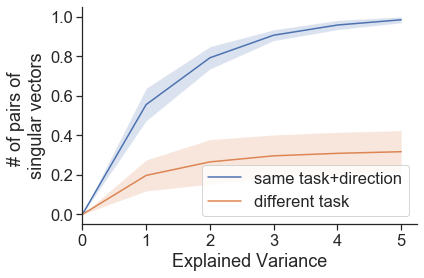

In [67]:
NSTD = 1.96



d1 = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[0]
d2 = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[1]
d1 = np.concatenate([[0],d1]); d2 = np.concatenate([[0],d2])

d1_sem = stt.sem(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[0]
d2_sem = stt.sem(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[1]

d1_sem = np.concatenate([[0],d1_sem])
d2_sem = np.concatenate([[0],d2_sem])

nT = d1.shape[0]

#d1 = np.cumsum(np(np.array([np.array(i)[:,:,:120] for i in all_res]),axis=(0,1))[0])
#d2 = np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res]),axis=(0,1))[1])

plt.plot(d1,label='same task+direction')
plt.fill_between(np.arange(nT),d1-NSTD*d1_sem,d1+NSTD*d1_sem,alpha=.2)

plt.plot(d2,label='different task')
plt.fill_between(np.arange(nT),d2-NSTD*d2_sem,d2+NSTD*d2_sem,alpha=.2)

#plt.plot(np.concatenate([[0],d2_dir]),label='different direction')
#plt.fill_between(np.arange(nT),d2-NSTD*d2_sem,d2+NSTD*d2_sem,alpha=.2)

#plt.xlim(0,25)
plt.xlabel("Explained Variance")
plt.ylabel("# of pairs of \nsingular vectors")
plt.legend()
plt.xlim(0)
seaborn.despine()

In [1493]:
d1

array([0.        , 0.58605773, 0.8093179 , 0.90441415, 0.9554103 ,
       0.98442121])

In [1494]:
d1_shuff

array([0.        , 0.31645253, 0.4511081 , 0.51978146, 0.54732967,
       0.56113612])

# Now do the shuffle control

In [1495]:
np.random.permutation(seq1)

array([2, 4, 3, 8, 1, 0, 5, 6, 7])

In [1522]:


all_res_uv = []
for sess_ix in range(8):
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
    roll_res = []
    seq1 = np.random.permutation(seq1)
    try:
        for roll_nr in range(9):
            for flip_nr in range(2):
                seq1_use = seq1.copy()
                frm = firing_rate_maps.copy()

                if flip_nr: seq1_use= np.flipud(seq1_use)
                seq1_use = np.roll(seq1_use,roll_nr)



                #neuron_nr,int(port),int(task),dix,half
                frm[:,:,0] = frm.swapaxes(0,1)[seq0,:,0].swapaxes(0,1)
                frm[:,:,1] = frm.swapaxes(0,1)[seq1_use,:,1].swapaxes(0,1)
                mx = np.nanmax(frm,axis=(1,2,3,4))
                frm = frm[np.logical_and(mx>2,mx<50)]

                selected = ~np.isnan(np.sum(frm,axis=(0,2,3,4)))
                frm = frm[:,selected]
                frm2 = frm.copy()
                select_data = lambda task,direction,half,fr: subset_data(fr,task,direction,half)

                res = []
                for ref,cv in zip([0,1],[1,0]):
                    for tar in [0,1]:
                        for dir1 in [0,1]:
                            for task1,task2 in zip([0,1],[1,0]):

                                #print(task1==task2)
                                dset1 = select_data(task=task1,direction=dir1,half=ref,fr=frm2)
                                dset2 = select_data(task=task1,direction=dir1,half=cv,fr=frm2)
                                dset3 = select_data(task=task2,direction=dir1,half=tar,fr=frm2)


                                #afg
                                #1/0
                                #break
                                dset1 = dset1 - np.mean(dset1,axis=1)[:,None]
                                dset2 = dset2 - np.mean(dset2,axis=1)[:,None]
                                dset3 = dset3 - np.mean(dset3,axis=1)[:,None]
                                #if you don't de-mean here, you are losing information about differences
                                #in mean firing rate...
                                tmp = variance_explained_both(dset1,dset2,dset3)
                                res.append(tmp)
                #print(sess_ix,np.array(res).shape)
                roll_res.append(res)
        #break
        cm_sum = np.nansum(np.mean(np.array(roll_res),axis=1)[:,1],axis=-1)
        all_res_uv.append(roll_res[np.argmax(cm_sum)])
    except:
        pass

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


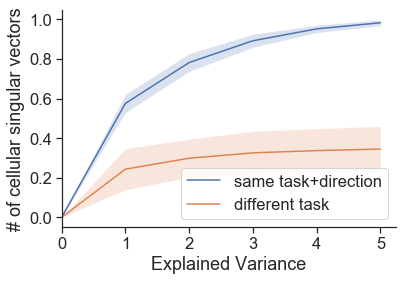

In [1523]:
NSTD = 1.96



d1_shuff = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[0]
d2_shuff = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[1]
d1_shuff = np.concatenate([[0],d1_shuff]); d2_shuff = np.concatenate([[0],d2_shuff])

d1_shuff_sem = stt.sem(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[0]
d2_shuff_sem = stt.sem(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[1]

d1_shuff_sem = np.concatenate([[0],d1_shuff_sem])
d2_shuff_sem = np.concatenate([[0],d2_shuff_sem])

nT = d1_shuff.shape[0]

#d1_shuff = np.cumsum(np(np.array([np.array(i)[:,:,:120] for i in all_res]),axis=(0,1))[0])
#d2_shuff = np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res]),axis=(0,1))[1])

plt.plot(d1_shuff,label='same task+direction')
plt.fill_between(np.arange(nT),d1_shuff-NSTD*d1_shuff_sem,d1_shuff+NSTD*d1_shuff_sem,alpha=.2)

plt.plot(d2_shuff,label='different task')
plt.fill_between(np.arange(nT),d2_shuff-NSTD*d2_shuff_sem,d2_shuff+NSTD*d2_shuff_sem,alpha=.2)

#plt.plot(np.concatenate([[0],d2_shuff_dir]),label='different direction')
#plt.fill_between(np.arange(nT),d2_shuff-NSTD*d2_shuff_sem,d2_shuff+NSTD*d2_shuff_sem,alpha=.2)

#plt.xlim(0,25)
plt.xlabel("Explained Variance")
plt.ylabel("# of cellular singular vectors")
plt.legend()
plt.xlim(0)
seaborn.despine()

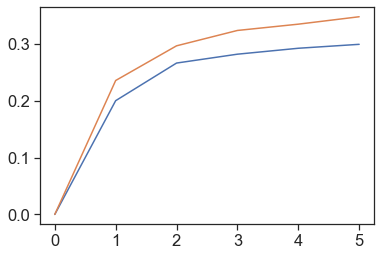

In [1505]:
plt.plot(d2)
plt.plot(d2_shuff)

# Now get a bunch of shuffles

In [1541]:
all_shuffs = []

for _ in range(100):

    all_res_uv = []
    for sess_ix in range(8):
        firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
        roll_res = []
        seq0 = np.random.permutation(seq1)
        try:
            for roll_nr in range(9):
                for flip_nr in range(2):
                    seq1_use = seq1.copy()
                    frm = firing_rate_maps.copy()

                    if flip_nr: seq1_use= np.flipud(seq1_use)
                    seq1_use = np.roll(seq1_use,roll_nr)



                    #neuron_nr,int(port),int(task),dix,half
                    frm[:,:,0] = frm.swapaxes(0,1)[seq0,:,0].swapaxes(0,1)
                    frm[:,:,1] = frm.swapaxes(0,1)[seq1_use,:,1].swapaxes(0,1)
                    mx = np.nanmax(frm,axis=(1,2,3,4))
                    frm = frm[np.logical_and(mx>2,mx<50)]

                    selected = ~np.isnan(np.sum(frm,axis=(0,2,3,4)))
                    frm = frm[:,selected]
                    frm2 = frm.copy()
                    select_data = lambda task,direction,half,fr: subset_data(fr,task,direction,half)

                    res = []
                    for ref,cv in zip([0,1],[1,0]):
                        for tar in [0,1]:
                            for dir1 in [0,1]:
                                for task1,task2 in zip([0,1],[1,0]):

                                    #print(task1==task2)
                                    dset1 = select_data(task=task1,direction=dir1,half=ref,fr=frm2)
                                    dset2 = select_data(task=task1,direction=dir1,half=cv,fr=frm2)
                                    dset3 = select_data(task=task2,direction=dir1,half=tar,fr=frm2)


                                    #afg
                                    #1/0
                                    #break
                                    dset1 = dset1 - np.mean(dset1,axis=1)[:,None]
                                    dset2 = dset2 - np.mean(dset2,axis=1)[:,None]
                                    dset3 = dset3 - np.mean(dset3,axis=1)[:,None]
                                    #if you don't de-mean here, you are losing information about differences
                                    #in mean firing rate...
                                    tmp = variance_explained_both(dset1,dset2,dset3)
                                    res.append(tmp)
                    #print(sess_ix,np.array(res).shape)
                    roll_res.append(res)
            #break
            cm_sum = np.nansum(np.mean(np.array(roll_res),axis=1)[:,1],axis=-1)
            all_res_uv.append(roll_res[np.argmax(cm_sum)])
        except:
            pass
    d2_shuff = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:5] for i in all_res_uv]),axis=1),axis=2),axis=0)[1]
    all_shuffs.append(d2_shuff)


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

In [1542]:
stt.percentileofscore(np.array(all_shuffs)[:,-1],d2[-1])

6.0

In [1543]:
mu = np.concatenate([[0],np.mean(all_shuffs,axis=0)])
sem = np.concatenate([[0],stt.sem(all_shuffs,axis=0)])

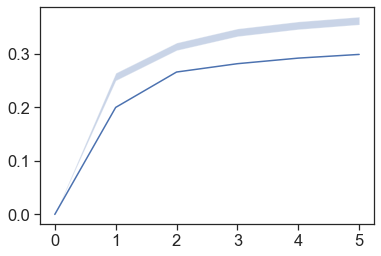

In [1544]:
plt.fill_between(np.arange(6),mu-2*sem,mu+2*sem,alpha=.3)
plt.plot(d2)

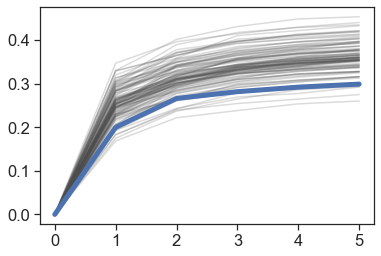

In [1545]:
for i in all_shuffs:
    plt.plot(np.concatenate([[0],i]),color='.3',alpha=.2)
    
plt.plot(d2,linewidth=5)


# Now only look at temporal SVs

In [1466]:
all_res_uv = []
for sess_ix in range(8):
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
    roll_res = []
    try:
        for roll_nr in range(9):
            for flip_nr in range(2):
                seq1_use = seq1.copy()
                frm = firing_rate_maps.copy()

                if flip_nr: seq1_use= np.flipud(seq1_use)
                seq1_use = np.roll(seq1_use,roll_nr)



                #neuron_nr,int(port),int(task),dix,half
                frm[:,:,0] = frm.swapaxes(0,1)[seq0,:,0].swapaxes(0,1)
                frm[:,:,1] = frm.swapaxes(0,1)[seq1_use,:,1].swapaxes(0,1)
                mx = np.nanmax(frm,axis=(1,2,3,4))
                frm = frm[np.logical_and(mx>1,mx<100)]

                selected = ~np.isnan(np.sum(frm,axis=(0,2,3,4)))
                frm = frm[:,selected]
                frm2 = frm.copy()
                select_data = lambda task,direction,half,fr: subset_data(fr,task,direction,half)

                res = []
                for ref,cv in zip([0,1],[1,0]):
                    for tar in [0,1]:
                        for dir1 in [0,1]:
                            for task1,task2 in zip([0,1],[1,0]):

                                #print(task1==task2)
                                dset1 = select_data(task=task1,direction=dir1,half=ref,fr=frm2)
                                dset2 = select_data(task=task1,direction=dir1,half=cv,fr=frm2)
                                dset3 = select_data(task=task2,direction=dir1,half=tar,fr=frm2)


                                #afg
                                #1/0
                                #break
                                dset1 = dset1 - np.mean(dset1,axis=1)[:,None]
                                dset2 = dset2 - np.mean(dset2,axis=1)[:,None]
                                dset3 = dset3 - np.mean(dset3,axis=1)[:,None]
                                #if you don't de-mean here, you are losing information about differences
                                #in mean firing rate...
                                tmp = variance_explained_V(dset1,dset2,dset3)
                                res.append(tmp)
                #print(sess_ix,np.array(res).shape)
                roll_res.append(res)
        #break
        cm_sum = np.nansum(np.mean(np.array(roll_res),axis=1)[:,1],axis=-1)
        all_res_uv.append(roll_res[np.argmax(cm_sum)])
    except:
        pass

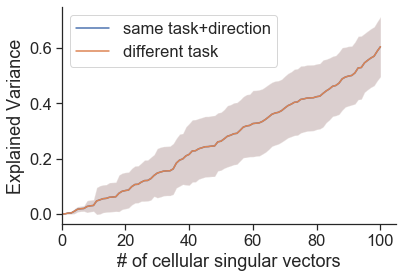

In [1469]:
NSTD = 1.96



d1 = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:100] for i in all_res_uv]),axis=1),axis=2),axis=0)[0]
d2_shuff = np.mean(np.cumsum(np.mean(np.array([np.array(i)[:,:,:100] for i in all_res_uv]),axis=1),axis=2),axis=0)[1]
d1 = np.concatenate([[0],d1]); d2_shuff = np.concatenate([[0],d2_shuff])

d1_sem = stt.sem(np.cumsum(np.mean(np.array([np.array(i)[:,:,:100] for i in all_res_uv]),axis=1),axis=2),axis=0)[0]
d2_shuff_sem = stt.sem(np.cumsum(np.mean(np.array([np.array(i)[:,:,:100] for i in all_res_uv]),axis=1),axis=2),axis=0)[1]

d1_sem = np.concatenate([[0],d1_sem])
d2_shuff_sem = np.concatenate([[0],d2_shuff_sem])

nT = d1.shape[0]

#d1 = np.cumsum(np(np.array([np.array(i)[:,:,:120] for i in all_res]),axis=(0,1))[0])
#d2_shuff = np.cumsum(np.mean(np.array([np.array(i)[:,:,:120] for i in all_res]),axis=(0,1))[1])

plt.plot(d1,label='same task+direction')
plt.fill_between(np.arange(nT),d1-NSTD*d1_sem,d1+NSTD*d1_sem,alpha=.2)

plt.plot(d2_shuff,label='different task')
plt.fill_between(np.arange(nT),d2_shuff-NSTD*d2_shuff_sem,d2_shuff+NSTD*d2_shuff_sem,alpha=.2)

#plt.plot(np.concatenate([[0],d2_shuff_dir]),label='different direction')
#plt.fill_between(np.arange(nT),d2_shuff-NSTD*d2_shuff_sem,d2_shuff+NSTD*d2_shuff_sem,alpha=.2)

#plt.xlim(0,25)
plt.ylabel("Explained Variance")
plt.xlabel("# of cellular singular vectors")
plt.legend()
plt.xlim(0)
seaborn.despine()